In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# generate transitions

#  these are fixed
transitions_0 = np.eye(4)
transitions_1 = np.zeros([4,4])
transitions_1[:,-1] = 0.1
transitions_1[-1,-1] = 0

#  these are the ones we want to learn
indices = np.array([[0,1],
                  [0,2],
                  [1,0],
                  [1,2],
                  [2,0],
                  [2,1],
                  [3,0],
                  [3,1]])


transitions_1[indices[:,0],indices[:,1]] = 0.45
transitions_1[3,2] = 0.1
transitions_1

transitions = {0: transitions_0,
               1: transitions_1}

transitions[0], transitions[1]

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0.  , 0.45, 0.45, 0.1 ],
        [0.45, 0.  , 0.45, 0.1 ],
        [0.45, 0.45, 0.  , 0.1 ],
        [0.45, 0.45, 0.1 , 0.  ]]))

In [2]:
def print_progress(states):
    for i in states.keys():
        print(i, states[i].progress, states[i].completed)
        
def get_active_states(states, return_ix=False):
    d = {}
    for s in states.keys():
        if not states[s].completed:
            d[s] =   states[s]
    if return_ix:
        return np.array(list(d.keys()))
    return d


#  Basic reward function
class Reward:
    def __init__(self, states, streaks, streak_length, streak_reward, So_p_reward=0.9):
        self.streaks = streaks
        self.streak_length = streak_length
        self.last_streak_init = 0
        self.states = states
        self.streak_reward = streak_reward
        self.So_p_reward = So_p_reward
        
    def __call__(self, current_state_ix, action_history, n_tasks_completed):
        state = self.states[current_state_ix]
        if action_history[-1]:
            self.last_streak_init = len(action_history)
            return -1

        # if we stay, we might get a reward    
        if state.state_length < 1000: # if we are in task state
            if state.completed: # if task completed, get big money!
                return 100**(n_tasks_completed) + state.state_length
            else: 
                if self.streaks and (current_state_ix != 3):
                    a = action_history[self.last_streak_init:self.last_streak_init+self.streak_length]
                    if (np.sum(a) == 0) and len(a) == self.streak_length:
                        self.last_streak_init = self.last_streak_init+self.streak_length
                        return self.streak_reward
                return -1
        else: # if we are in other state
            v = npr.binomial(1, self.So_p_reward) # return random reward
#             return 2*(1-v) - v
            return 2*(v) - (1-v)


        
        
# def reward(state, action_history):
#     # if we just switched, always penalize
#     if action_history[-1]:
#         return -1
    
#     # if we stay, we might get a reward    
#     if state.state_length < 1000: # if we are in task state
#         if state.completed: # if task completed, get big money!
#             return 100**(self.n_tasks_completed) + state.state_length
#         else: 
#             return -1
#     else: # if we are in other state
#         v = npr.binomial(1, 0.9) # return random reward
#         return 2*(1-v) - v

    



In [3]:
class Task_Timer:
    def __init__(self, states, on_break, max_decrement=30):
        self.states = states
        self.on_break = on_break
        self.max_decrement = max_decrement
        
    def step(self, current_state_ix, action):
        states = get_active_states(self.states)
        states_ix = get_active_states(self.states, True)
    
        if action: # if we switched, decrement progress of all active states
            for s in states.keys():
                if states[s].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[s].progress = max(0, states[s].progress -1)
                    states[s].n_decrement += 1
                
        else:
            states[current_state_ix].progress += 1 # increment progress on current state
            
            if states[current_state_ix].progress >= states[current_state_ix].state_length-1: 
                states[current_state_ix].completed = True
                
            
            s_ = np.setdiff1d(states_ix, current_state_ix)
            for i in s_:
                if states[i].n_decrement < self.max_decrement:
                    if not self.on_break:
                        states[i].progress = max(0, states[i].progress-1)
                    states[i].n_decrement += 1
                

            
            
            
        

In [4]:
import numpy.random as npr
import numpy as np

class State:
    def __init__(self, state_length):
        self.state_length = state_length
        self.progress = 0
        self.completed = False
        self.n_decrement = 0

class MDP:
    def __init__(self, 
                 reward, 
                 task_timer, 
                 transitions, 
                 init_state=None, 
                 Break = False, 
                 break_length = 15,
                 Streaks = True, 
                 streak_length = 10,
                 streak_reward = 10,
                 So_reward_p = 0.1):
        '''
        transitions: ()
        init_state: (int)
        '''
        
        # Time Horizon is 8 hours
        self.T = 60*8 
        
        # init states
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        self.init_state = init_state
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
            
        self.transitions = transitions
        self.n_tasks_completed = 0
        
        
        self.Break = Break
        self.on_break = False
        self.break_counter = 0
        self.break_length = break_length
        
        self.task_timer = task_timer(self.states, self.on_break)
        
        
        self.Streaks = Streaks
        self.streak_length = streak_length
        self.streak_reward = streak_reward
        self.So_reward_p = So_reward_p

        self.reward = reward
        self.reward_fn = self.reward(self.states, 
                                self.Streaks, 
                                self.streak_length,
                               self.streak_reward,
                               self.So_reward_p)
        
        self.action_history = []
    
    def __call__(self, action):
        '''Take a step 
        0 is stay
        1 is transition'''
        self.action_history.append(action)
        if action:
            if self.on_break:
                self.on_break = False
                self.task_timer.on_break = False
            # get candidate transitions and probabilities
            s = get_active_states(self.states, True)
            self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            p=self.transitions[1][self.current_state_ix, s]
            
            # reset n_decrement
            self.states[self.current_state_ix].n_decrement = 0
        
            # randomly sample
            self.current_state_ix = npr.choice(s, p=p)    
        else:
            if self.on_break and self.current_state_ix == 3:
                self.break_counter += 1
            
                if self.break_counter >= self.break_length: 
                    # done with break
                    s = get_active_states(self.states, True)
                    self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
                    p=self.transitions[1][self.current_state_ix, s]
                    self.current_state_ix = npr.choice(s, p=p)    
                    self.on_break = False
                    self.task_timer.on_break = False
                    
            pass
        
        self.task_timer.step(self.current_state_ix, action)          
        r = self.reward_fn(self.current_state_ix, self.action_history, self.n_tasks_completed)
        
        # if we complete the task, sample a new task
        if self.states[self.current_state_ix].completed:
            s = get_active_states(self.states, True)
            self.transitions[1][self.current_state_ix,s] = normalize(self.transitions[1][self.current_state_ix,s])
            p = self.transitions[1][self.current_state_ix,s]
            self.current_state_ix = npr.choice(s, p=p)
            self.n_tasks_completed += 1
            
            if self.Break:
                self.current_state_ix = 3
                self.on_break = True
                self.task_timer.on_break = True
                self.break_counter = 0
                
            
        self.total_reward += r
        return self.current_state_ix, r
    
    def get_state_ix(self):
        return self.current_state_ix
    
    def get_state(self):
        return self.states[self.current_state_ix]
    
    def reset(self):
        self.Ss = State(60)
        self.Sm = State(120)
        self.Sl = State(240)
        self.So = State(10e9) # distracted
        self.states = {0: self.Ss,
                      1: self.Sm,
                      2: self.Sl,
                      3: self.So}
        
        
        self.total_reward = 0
        
        if self.init_state is None:
            self.current_state_ix = npr.choice(3) # only start in task state
        else:
            self.current_state_ix = self.init_state
            
        self.transitions = transitions
        self.n_tasks_completed = 0
        self.action_history = []
        
        self.on_break = False
        
        self.task_timer.states = self.states
        self.task_timer.on_break = self.on_break
        
        self.reward_fn.states = self.states


        
def normalize(p):
    return p/p.sum()

def fake_agent(s, r):
    # random action
    return npr.choice(2, p=[0.99, 0.01])


mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          None, 
          Break=False, 
          Streaks=False)
self = mdp
    
    

    
        
        

In [5]:
class Agent:
    def __init__(self, 
                 discount_factor = 0.9,
                 learning_rate = 0.9,
                 weight_1 = 0.2, 
                 weight_2 = 0.1, 
                 weight_3 = 0.2,
                 weight_4 = 0.1,
                 a = 0,
                 epsilon = 0.05):
        
        self.Qn = npr.randn(4, 2)*0.01
        self.Qp = npr.randn(4, 2)*0.01
        self.Q = np.zeros((4, 2))

        self.weight_1 = weight_1
        self.weight_2 = weight_2
        self.weight_3 = weight_3
        self.weight_4 = weight_4
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        
        self.a = 0
        
        self.epsilon = epsilon
        

#     def choose_action(self, s, r):
#         s_idx = mdp.get_state_ix()
        
#         # TODO: check that not all states are complete
#         self.Q[s_idx, self.a] = self.weight_2 * self.Qp[s_idx, self.a] + self.weight_4 * self.Qn[s_idx, self.a]
#         self.a = np.argmax(self.Q[s_idx])
#         new_s,_ = mdp(self.a)
#         new_s_idx = mdp.get_state_ix()

#         self.Qp[s_idx, self.a] = self.weight_1 * self.Qp[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[new_s_idx]) - self.Qp[s_idx, self.a])
#         self.Qn[s_idx, self.a] = self.weight_3 * self.Qn[s_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[new_s_idx]) - self.Qn[s_idx, self.a])

#         return np.argmax(self.Q[s_idx]) 
    
    def choose_action(self, s_idx):
        p = np.random.random()
        if p < self.epsilon:
          return np.random.choice([0,1]) 
        else:
          return np.argmax(self.Q[s_idx])
        
    def update(self, s0_idx, s1_idx, r):
        
        # TODO: check that not all states are complete
        self.Q[s0_idx, self.a] = self.weight_2 * self.Qp[s0_idx, self.a] + self.weight_4 * self.Qn[s0_idx, self.a]
        
        self.a = np.argmax(self.Q[s0_idx])

        if r > 0: 
            self.Qp[s0_idx, self.a] = self.weight_1 * self.Qp[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qp[s1_idx]) - self.Qp[s0_idx, self.a])
        else:
            self.Qn[s0_idx, self.a] = self.weight_3 * self.Qn[s0_idx, self.a] + self.learning_rate * (r + self.discount_factor * np.max(self.Qn[s1_idx]) - self.Qn[s0_idx, self.a])
        
    def reset(self,):
        self.Qn = npr.random((4, 2))*0.1
        self.Qp = npr.random((4, 2))*0.1
        self.a = 0
        self.Q = npr.random((4, 2))

In [7]:
class Episodes:
    def __init__(self, mdp, agent, n_episodes, verbose=True):
        self.mdp = mdp
        self.agent = agent
        self.EPISODES_NUM = n_episodes
        self.prog = [[] for _ in range(self.EPISODES_NUM)]
        self.actions = [[] for _ in range(self.EPISODES_NUM)]
        self.states = [[] for _ in range(self.EPISODES_NUM)]
        self.rewards = [[] for _ in range(self.EPISODES_NUM)]
        self.on_break = [[] for _ in range(self.EPISODES_NUM)]
        self.score = [[] for _ in range(self.EPISODES_NUM)]
        self.time_horizon = 480
        
        self.verbose= verbose
        
        
    def run(self, ):
        #if self.verbose:
            #print(f"Running {self.EPISODES_NUM} episodes")
        for i in range(self.EPISODES_NUM):
            self.mdp.reset() # reset mdp for every episode
#             self.agent.reset() # reset agent for every episode
            
            s0 = self.mdp.get_state_ix()
            for j in range(self.time_horizon):

                a = self.agent.choose_action(s0)
                s1, r = self.mdp(a)
                s1 = self.mdp.get_state_ix()
                self.agent.update(s0, s1, r)
                s0 = s1

                p_ = [mdp.states[k].progress for k in range(4)]

                self.prog[i].append(p_)
                self.actions[i].append(a)
                self.states[i].append(self.mdp.current_state_ix)
                self.rewards[i].append(r)
                self.on_break[i].append(self.mdp.on_break)

                active_states = get_active_states(self.mdp.states,True)
                if len(active_states) == 1:
                    break
                    
            self.score[i] = np.sum(self.rewards[i])
            #if self.verbose:
                #print(f"\tEpisode: {i}\tScore: {self.score[i]}")

In [9]:
# mdp.states[0].progress


In [8]:
mdp(0)

(1, -1)

In [9]:

import time
    
# have a way of constructing valid transition matrices so that each row is a valid probability. 
# How many "sliders" or "knobs" do you need? 


t1 = time.time()
initial_state = 1

mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
         streak_length=10)

agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
n_episodes = 60
episode = Episodes(mdp, agent, n_episodes)
episode.run()
time.time() - t1

1.2263092994689941

In [10]:
import random as rand
# n_samples for random search = 4,000
def RandomSearch(transitions, n_samples=4000):
    params = {}
    
    for i in range(n_samples):
        print(i)
        
        initial_state = rand.randrange(0,2)
        Break = bool(rand.getrandbits(1))
        break_length = rand.randrange(5,60,5)
        Streaks = bool(rand.getrandbits(1))
        streak_length = rand.randrange(10,90,5)
        transitions = {0: transitions_0,
               1: []}
        
        offtask = 0.1
        rand_1 = rand.uniform(0, 1-offtask)
        rand_2 = rand.uniform(0, 1-offtask)
        rand_3 = rand.uniform(0, 1-offtask)
        rand_4 = npr.dirichlet(np.ones(3),size=1)[0]
        
        transitions[1] = [[0., rand_1, 1-offtask-rand_1, offtask],
                              [rand_2, 0., 1-offtask-rand_2, offtask],
                              [rand_3, 1-offtask-rand_3, 0., offtask],
                              [rand_4[0], rand_4[1], rand_4[2], 0.]]

        mdp = MDP(Reward, 
          Task_Timer,  
          transitions, 
          initial_state, 
          Break=True,
          break_length = 10,
          Streaks=False,
          streak_length=10)
        print(transitions[1][0][3])
        agent = Agent(epsilon=0.1) # epsilon is the probability of "exploring" vs exploiting
        n_episodes = 50
        episode = Episodes(mdp, agent, n_episodes)
        episode.run()
        expected_score = np.median(episode.score)
        
        params[i] = {"transition parameter 1": rand_1,
                    "transition parameter 2": rand_2,
                    "transition parameter 3": rand_3,
                    "transition parameter 4": rand_4[0],
                    "transition parameter 5": rand_4[1],
                    "transition parameter 6": rand_4[2],
                    "break": Break,
                    "streaks": Streaks,
                    "break_length": break_length,
                    "streak_length": streak_length,
                    "expected score": expected_score}
        
    return params

In [11]:
import json

params = RandomSearch(transitions, 4000)
with open("random_search.json", "w") as write_file:
    json.dump(params, write_file, indent=4)

0
0.1
1
0.1
2
0.1
3
0.1
4
0.1
5
0.1
6
0.1
7
0.1
8
0.1
9
0.1
10
0.1
11
0.1
12
0.1
13
0.1
14
0.1
15
0.1
16
0.1
17
0.1
18
0.1
19
0.1
20
0.1
21
0.1
22
0.1
23
0.1
24
0.1
25
0.1
26
0.1
27
0.1
28
0.1
29
0.1
30
0.1
31
0.1
32
0.1
33
0.1
34
0.1
35
0.1
36
0.1
37
0.1
38
0.1
39
0.1
40
0.1
41
0.1
42
0.1
43
0.1
44
0.1
45
0.1
46
0.1
47
0.1
48
0.1
49
0.1
50
0.1
51
0.1
52
0.1
53
0.1
54
0.1
55
0.1
56
0.1
57
0.1
58
0.1
59
0.1
60
0.1
61
0.1
62
0.1
63
0.1
64
0.1
65
0.1
66
0.1
67
0.1
68
0.1
69
0.1
70
0.1
71
0.1
72
0.1
73
0.1
74
0.1
75
0.1
76
0.1
77
0.1
78
0.1
79
0.1
80
0.1
81
0.1
82
0.1
83
0.1
84
0.1
85
0.1
86
0.1
87
0.1
88
0.1
89
0.1
90
0.1
91
0.1
92
0.1
93
0.1
94
0.1
95
0.1
96
0.1
97
0.1
98
0.1
99
0.1
100
0.1
101
0.1
102
0.1
103
0.1
104
0.1
105
0.1
106
0.1
107
0.1
108
0.1
109
0.1
110
0.1
111
0.1
112
0.1
113
0.1
114
0.1
115
0.1
116
0.1
117
0.1
118
0.1
119
0.1
120
0.1
121
0.1
122
0.1
123
0.1
124
0.1
125
0.1
126
0.1
127
0.1
128
0.1
129
0.1
130
0.1
131
0.1
132
0.1
133
0.1
134
0.1
135
0.1
136
0.1
137
0.1
138
0.

1034
0.1
1035
0.1
1036
0.1
1037
0.1
1038
0.1
1039
0.1
1040
0.1
1041
0.1
1042
0.1
1043
0.1
1044
0.1
1045
0.1
1046
0.1
1047
0.1
1048
0.1
1049
0.1
1050
0.1
1051
0.1
1052
0.1
1053
0.1
1054
0.1
1055
0.1
1056
0.1
1057
0.1
1058
0.1
1059
0.1
1060
0.1
1061
0.1
1062
0.1
1063
0.1
1064
0.1
1065
0.1
1066
0.1
1067
0.1
1068
0.1
1069
0.1
1070
0.1
1071
0.1
1072
0.1
1073
0.1
1074
0.1
1075
0.1
1076
0.1
1077
0.1
1078
0.1
1079
0.1
1080
0.1
1081
0.1
1082
0.1
1083
0.1
1084
0.1
1085
0.1
1086
0.1
1087
0.1
1088
0.1
1089
0.1
1090
0.1
1091
0.1
1092
0.1
1093
0.1
1094
0.1
1095
0.1
1096
0.1
1097
0.1
1098
0.1
1099
0.1
1100
0.1
1101
0.1
1102
0.1
1103
0.1
1104
0.1
1105
0.1
1106
0.1
1107
0.1
1108
0.1
1109
0.1
1110
0.1
1111
0.1
1112
0.1
1113
0.1
1114
0.1
1115
0.1
1116
0.1
1117
0.1
1118
0.1
1119
0.1
1120
0.1
1121
0.1
1122
0.1
1123
0.1
1124
0.1
1125
0.1
1126
0.1
1127
0.1
1128
0.1
1129
0.1
1130
0.1
1131
0.1
1132
0.1
1133
0.1
1134
0.1
1135
0.1
1136
0.1
1137
0.1
1138
0.1
1139
0.1
1140
0.1
1141
0.1
1142
0.1
1143
0.1
1144
0.1
1

1945
0.1
1946
0.1
1947
0.1
1948
0.1
1949
0.1
1950
0.1
1951
0.1
1952
0.1
1953
0.1
1954
0.1
1955
0.1
1956
0.1
1957
0.1
1958
0.1
1959
0.1
1960
0.1
1961
0.1
1962
0.1
1963
0.1
1964
0.1
1965
0.1
1966
0.1
1967
0.1
1968
0.1
1969
0.1
1970
0.1
1971
0.1
1972
0.1
1973
0.1
1974
0.1
1975
0.1
1976
0.1
1977
0.1
1978
0.1
1979
0.1
1980
0.1
1981
0.1
1982
0.1
1983
0.1
1984
0.1
1985
0.1
1986
0.1
1987
0.1
1988
0.1
1989
0.1
1990
0.1
1991
0.1
1992
0.1
1993
0.1
1994
0.1
1995
0.1
1996
0.1
1997
0.1
1998
0.1
1999
0.1
2000
0.1
2001
0.1
2002
0.1
2003
0.1
2004
0.1
2005
0.1
2006
0.1
2007
0.1
2008
0.1
2009
0.1
2010
0.1
2011
0.1
2012
0.1
2013
0.1
2014
0.1
2015
0.1
2016
0.1
2017
0.1
2018
0.1
2019
0.1
2020
0.1
2021
0.1
2022
0.1
2023
0.1
2024
0.1
2025
0.1
2026
0.1
2027
0.1
2028
0.1
2029
0.1
2030
0.1
2031
0.1
2032
0.1
2033
0.1
2034
0.1
2035
0.1
2036
0.1
2037
0.1
2038
0.1
2039
0.1
2040
0.1
2041
0.1
2042
0.1
2043
0.1
2044
0.1
2045
0.1
2046
0.1
2047
0.1
2048
0.1
2049
0.1
2050
0.1
2051
0.1
2052
0.1
2053
0.1
2054
0.1
2055
0.1
2

2856
0.1
2857
0.1
2858
0.1
2859
0.1
2860
0.1
2861
0.1
2862
0.1
2863
0.1
2864
0.1
2865
0.1
2866
0.1
2867
0.1
2868
0.1
2869
0.1
2870
0.1
2871
0.1
2872
0.1
2873
0.1
2874
0.1
2875
0.1
2876
0.1
2877
0.1
2878
0.1
2879
0.1
2880
0.1
2881
0.1
2882
0.1
2883
0.1
2884
0.1
2885
0.1
2886
0.1
2887
0.1
2888
0.1
2889
0.1
2890
0.1
2891
0.1
2892
0.1
2893
0.1
2894
0.1
2895
0.1
2896
0.1
2897
0.1
2898
0.1
2899
0.1
2900
0.1
2901
0.1
2902
0.1
2903
0.1
2904
0.1
2905
0.1
2906
0.1
2907
0.1
2908
0.1
2909
0.1
2910
0.1
2911
0.1
2912
0.1
2913
0.1
2914
0.1
2915
0.1
2916
0.1
2917
0.1
2918
0.1
2919
0.1
2920
0.1
2921
0.1
2922
0.1
2923
0.1
2924
0.1
2925
0.1
2926
0.1
2927
0.1
2928
0.1
2929
0.1
2930
0.1
2931
0.1
2932
0.1
2933
0.1
2934
0.1
2935
0.1
2936
0.1
2937
0.1
2938
0.1
2939
0.1
2940
0.1
2941
0.1
2942
0.1
2943
0.1
2944
0.1
2945
0.1
2946
0.1
2947
0.1
2948
0.1
2949
0.1
2950
0.1
2951
0.1
2952
0.1
2953
0.1
2954
0.1
2955
0.1
2956
0.1
2957
0.1
2958
0.1
2959
0.1
2960
0.1
2961
0.1
2962
0.1
2963
0.1
2964
0.1
2965
0.1
2966
0.1
2

3767
0.1
3768
0.1
3769
0.1
3770
0.1
3771
0.1
3772
0.1
3773
0.1
3774
0.1
3775
0.1
3776
0.1
3777
0.1
3778
0.1
3779
0.1
3780
0.1
3781
0.1
3782
0.1
3783
0.1
3784
0.1
3785
0.1
3786
0.1
3787
0.1
3788
0.1
3789
0.1
3790
0.1
3791
0.1
3792
0.1
3793
0.1
3794
0.1
3795
0.1
3796
0.1
3797
0.1
3798
0.1
3799
0.1
3800
0.1
3801
0.1
3802
0.1
3803
0.1
3804
0.1
3805
0.1
3806
0.1
3807
0.1
3808
0.1
3809
0.1
3810
0.1
3811
0.1
3812
0.1
3813
0.1
3814
0.1
3815
0.1
3816
0.1
3817
0.1
3818
0.1
3819
0.1
3820
0.1
3821
0.1
3822
0.1
3823
0.1
3824
0.1
3825
0.1
3826
0.1
3827
0.1
3828
0.1
3829
0.1
3830
0.1
3831
0.1
3832
0.1
3833
0.1
3834
0.1
3835
0.1
3836
0.1
3837
0.1
3838
0.1
3839
0.1
3840
0.1
3841
0.1
3842
0.1
3843
0.1
3844
0.1
3845
0.1
3846
0.1
3847
0.1
3848
0.1
3849
0.1
3850
0.1
3851
0.1
3852
0.1
3853
0.1
3854
0.1
3855
0.1
3856
0.1
3857
0.1
3858
0.1
3859
0.1
3860
0.1
3861
0.1
3862
0.1
3863
0.1
3864
0.1
3865
0.1
3866
0.1
3867
0.1
3868
0.1
3869
0.1
3870
0.1
3871
0.1
3872
0.1
3873
0.1
3874
0.1
3875
0.1
3876
0.1
3877
0.1
3

In [14]:
max_score = -500
sample = 0
for key, val in params.items():
    print(key)
    if val["expected score"] > max_score:
        max_score = val["expected score"]
        sample = key
print(sample)
print(params[sample])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672


In [11]:

# build a dictionary of dictionaries
# key is the "experiment", item is another dictionary of the parameters


{0: {"transition parameter 1": 0.6
    "transition parameter 2":0.3
    "transition parameter 3": 0.2
    "transition parameter 4": 0.1
    "transition parameter 5": 0.4
    "break": True/False,
    "streaks": True/False,
    "break_length": 20,
    "streak_length": 30,
    "expected score": -100},
1: ,
2:,
}



SyntaxError: invalid syntax. Perhaps you forgot a comma? (59409931.py, line 3)

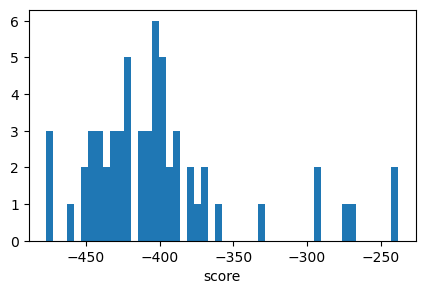

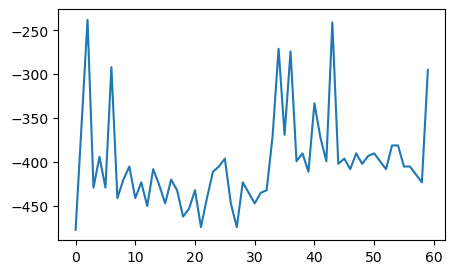

In [13]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

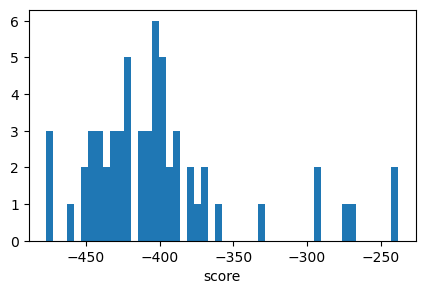

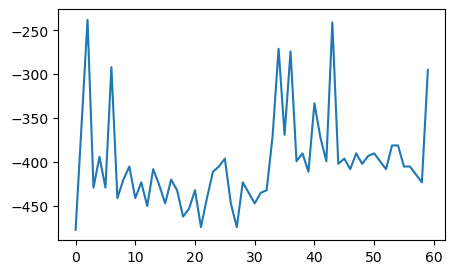

In [14]:

# distribution of scores (baseline set up)
plt.figure(figsize=(5,3))
plt.hist(episode.score, bins=50)
plt.xlabel('score')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(episode.score)
plt.show()

In [ ]:
# print(test.prog)
# print(test.actions)
# print(test.states)
# print(test.rewards)
# print(test.on_break)


In [ ]:
#  simple episode
# prog = []
# actions = []
# states = []
# rewards = []
# on_break = []
# on_break2 = []
# time_horizon = 480

# # get initial state/ set reward to 0
# s0 = mdp.get_state_ix()
# # s0 = mdp.get_state()
# r = 0
# agent = Agent()
# for i in range(time_horizon):
# #     a = fake_agent(s0, r)
# #     a = agent(s0, r)
    
#     a = agent.choose_action(s0)
#     s1, r = mdp(a)
#     s1 = mdp.get_state_ix()
#     agent.update(s0, s1, r)

#     # Q update
# #     break
    
#     s0 = s1

    
#     p_ = [self.states[k].progress for k in range(4)]
    
#     prog.append(p_)
#     actions.append(a)
#     states.append(self.current_state_ix)
#     rewards.append(r)
#     on_break.append(self.on_break)
#     on_break2.append(self.task_timer.on_break)
    
    
#     active_states = get_active_states(self.states,True)
#     if len(active_states) == 1:
#         break


# print(f'a:\t{a}')
# print(print_progress(self.states))

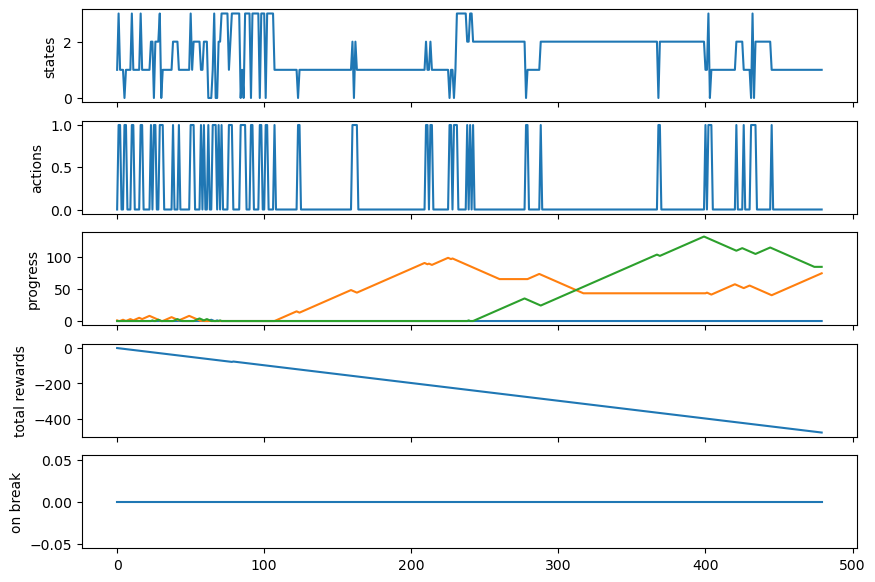

In [15]:

f, axs = plt.subplots(5,1, figsize=(10,7), sharex=True)

# index the episode you want to visualize
ep = 0

axs[0].plot(episode.states[ep])
axs[0].set_ylabel('states')
axs[1].plot(episode.actions[ep])
axs[1].set_ylabel('actions')
axs[2].plot(np.array(episode.prog[ep])[:,:-1])
axs[2].set_ylabel('progress')
axs[3].plot(np.cumsum(episode.rewards[ep]))
axs[3].set_ylabel('total rewards')
axs[4].plot(episode.on_break[ep])
axs[4].set_ylabel('on break')

# axs[3].set_yscale('log')

plt.show()

In [ ]:
agent.Qp